This notebook is to inspect the PSI-MAS datacubes using the psipy package

In [13]:
import warnings
warnings.filterwarnings('ignore')

import os
import glob
# import numpy as np
# import pandas as pd
# from scipy.io import readsav
import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# import astropy.io.fits as fits
# from astropy import units as u
# import astropy.constants as astro_const
# from astropy.coordinates import SkyCoord
# from astropy.utils.data import download_file
# from astropy.visualization import ImageNormalize, LogStretch, LogStretch, PercentileInterval
# import sunpy
# import sunpy.map
# from sunpy.map import Map
from sunpy.coordinates import sun
# from sunpy.coordinates import frames
# from sunpy.sun import constants as const
# from sunpy.coordinates import SphericalScreen
# import gzip
# import requests
# import urllib.request
# from datetime import datetime
# from bs4 import BeautifulSoup
# import pfsspy
# import pfsspy.tracing as tracing
# from sunkit_instruments import suvi
# from tqdm import tqdm

# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
import sys
if script_path not in sys.path:
    sys.path.append(script_path)

import fwdtools as fwd
import solar_data_utils as myfuncs

# Reload to update with new changes
import importlib
importlib.reload(fwd)
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7,7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

data_dir = '/home/mnedal/data'

In [ ]:
# YEAR = '2024'
# MONTH = '05'
# DAY = '14'
# HOUR = '17'
# MINUTE = '40'

# # construct the datetime object 
# mydatetime = datetime(int(YEAR), int(MONTH), int(DAY), int(HOUR), int(MINUTE))

# # get the Carrington rotation number at the specified datetime 
# cr = str(int(sun.carrington_rotation_number(t=mydatetime)))
# print(cr)

In [11]:
mydatetime = '2024-05-14T17:10'
year, month, day = mydatetime.split('T')[0].split('-')
hour, minute     = mydatetime.split('T')[1].split(':')
print(year, month, day, hour, minute) # sanity check

2024 05 14 17 10


In [12]:
# get the Carrington rotation number at the specified datetime 
cr = str(int(sun.carrington_rotation_number(t=mydatetime)))
print(cr)

2284


In [41]:
# mas_filename = [file for file in glob.glob(f'{data_dir}/*.dat') if file.split('/')[-1].startswith(cr)][0]
# print(mas_filename) # sanity check

### Use `psipy` package

In [29]:
from psipy.model import MASOutput

In [42]:
mas_path = f'{data_dir}/PSI_MAS/{year}{month}{day}_{hour}{minute}/'

model = MASOutput(mas_path)
print(mas_path) # sanity check

/home/mnedal/data/PSI_MAS/20240514_1710/


In [43]:
print(model.variables)

['bp', 'br', 'bt', 'cs', 'em', 'ep', 'heat', 'jp', 'jr', 'jt', 'p', 'rho', 't', 'va', 'vp', 'vr', 'vt']


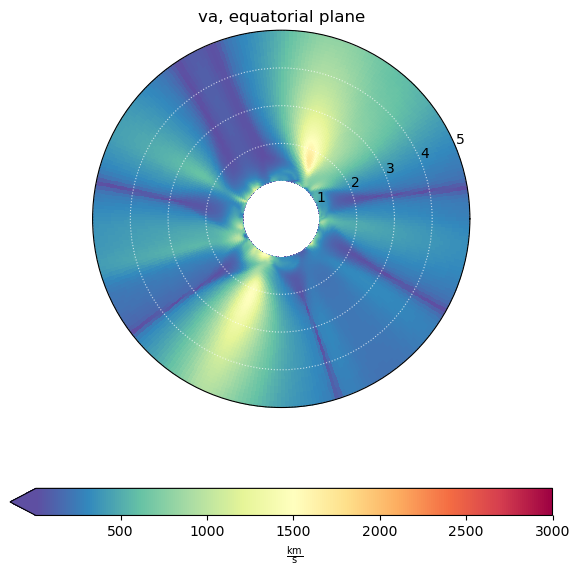

In [102]:
# Plotting equatorial slices
cbar_kwargs = {'orientation': 'horizontal'}

ax = plt.subplot(projection='polar')
model['va'].plot_equatorial_cut(ax=ax, cbar_kwargs=cbar_kwargs, vmin=10, vmax=3000, cmap='Spectral_r')
ax.grid(color='w', linestyle=':', alpha=0.7)
ax.set_ylim(0, 5)  # Limits the radial distance to 5
plt.show()

TypeError: get_horizons_coord() got an unexpected keyword argument 'observer'

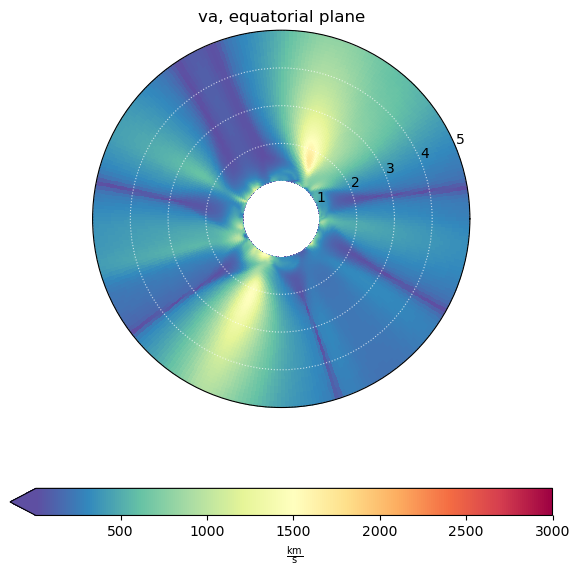

In [106]:
import sunpy.coordinates.ephemeris as eph
import astropy.units as u
import numpy as np

# Load MAS model
model = MASOutput(mas_path)

# Plotting equatorial slices
cbar_kwargs = {'orientation': 'horizontal'}
ax = plt.subplot(projection='polar')
model['va'].plot_equatorial_cut(ax=ax, cbar_kwargs=cbar_kwargs, vmin=10, vmax=3000, cmap='Spectral_r')
ax.grid(color='w', linestyle=':', alpha=0.7)
ax.set_ylim(0, 5) # Set the radial limit
# Get Earth's position in Carrington coordinates
earth_coord = eph.get_horizons_coord('399', time='now', id_type='majorbody', observer='Sun')

# Extract Carrington longitude (convert to radians) and radial distance
carrington_longitude = earth_coord.lon.to(u.rad).value  # Convert to radians
radial_distance = earth_coord.radius.to(u.R_sun).value  # Convert to solar radii

# Plot Earth’s location
ax.scatter(carrington_longitude, radial_distance, color='blue', label='Earth', s=100, marker='o')

ax.legend(loc='upper right')
plt.show()

In [208]:
from sunpy.coordinates import get_horizons_coord
from astropy.time import Time

time = Time('2024-05-14 17:10')
earth_coords = get_horizons_coord('399', time)

print(earth_coords)

2025-04-01 18:51:52 - sunpy - INFO: Obtained JPL HORIZONS location for Earth (399)                    


INFO: Obtained JPL HORIZONS location for Earth (399)                     [sunpy.coordinates.ephemeris]
<SkyCoord (HeliographicStonyhurst: obstime=2024-05-14 17:10:00.000, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, AU)
    (-8.32068281e-07, -2.67381706, 1.01079589)>


In [209]:
# Get Earth's Carrington longitude
carr_lon = earth_coords.lon.to(u.deg).value
# phi      = carr_lon * (np.pi/180)

# Convert longitude to radians for polar plot
theta = np.deg2rad(carr_lon)

# Define arrow start and end points
r_start = 2.5
r_end   = 4

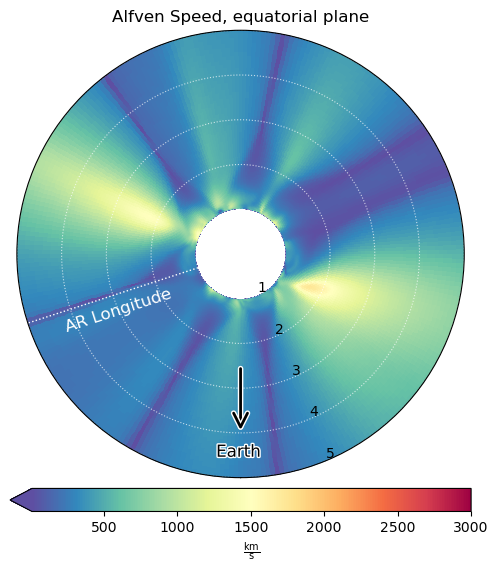

In [225]:
# Plot the MAS equatorial slice
cbar_kwargs = {
    'orientation': 'horizontal',
    'pad': 0.02, 'shrink': 0.85
}

ax = plt.subplot(projection='polar')
model['va'].plot_equatorial_cut(ax=ax, cbar_kwargs=cbar_kwargs, vmin=10, vmax=3000, cmap='Spectral_r')
ax.set_title('Alfven Speed, equatorial plane')

# ax.scatter(phi, 4, color='blue', marker='o', label='Earth') # Plot Earth's location

# Plot the arrow
arrow = ax.annotate('', 
            xy=(theta, r_end), xytext=(theta, r_start),
            arrowprops=dict(arrowstyle='->', color='k', lw=2, facecolor='k', edgecolor='w', mutation_scale=25))
import matplotlib.patheffects as path_effects  # For the white outline
arrow.arrow_patch.set_path_effects([
    path_effects.Stroke(linewidth=4, foreground='w'),  # White outline around arrow
    path_effects.Normal()  # Normal arrow on top
])
# Add the text "Earth" next to the arrow
text = ax.text(theta-0.01, r_end+0.6, 'Earth', color='k', fontsize=12, ha='center', va='bottom')
# Apply the white outline to the text
text.set_path_effects([
    path_effects.Stroke(linewidth=2, foreground='w'),  # White outline around text
    path_effects.Normal()  # Normal text on top
])

# Define the angle in degrees and convert to radians
angle_deg = -72
angle_rad = np.radians(angle_deg)
# Define the radius range
rLine_start = 1
rLine_end = 5
# Plot the dotted line from the Active Region, where the CME was launhed
rLine     = np.array([rLine_start, rLine_end]) # Define the radius range
thetaLine = np.array([angle_rad, angle_rad])   # Constant angle for the line
ax.plot(thetaLine, rLine, linestyle=':', color='w', lw=1)
# Add the text next to the line
text_radius = (rLine_start + rLine_end) / 2    # Midpoint of the radius range
ax.text(angle_rad+np.radians(7), text_radius, 'AR Longitude', color='w', fontsize=12, va='center', ha='center', rotation=angle_deg+90)

ax.grid(color='w', linestyle=':', alpha=0.7)
ax.set_ylim(0, 5) # Set the radial limit
ax.set_theta_offset(-np.pi/2) # Rotate the polar plot by 90 degrees (pi/2 radians)
plt.savefig(f'{data_dir}/valfven_equatorial_cut.pdf', format='pdf', bbox_inches='tight')
plt.show()

/home/mnedal/.cache/psipy/cr2210-medium/hmi_masp_mas_std_0201/helio
['bp', 'br', 'bt', 'rho', 'vr']


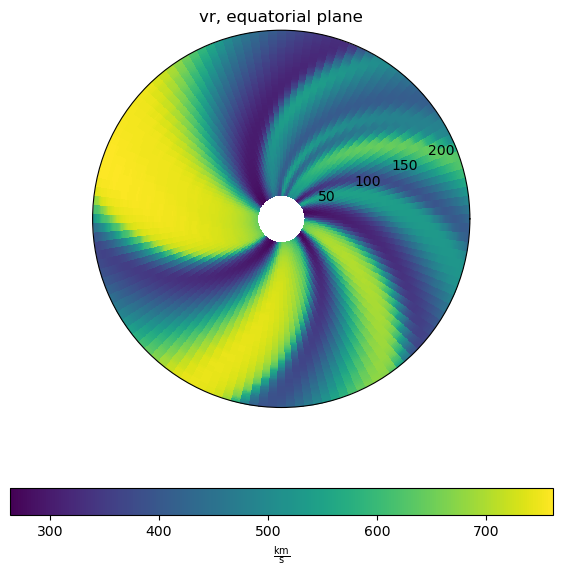

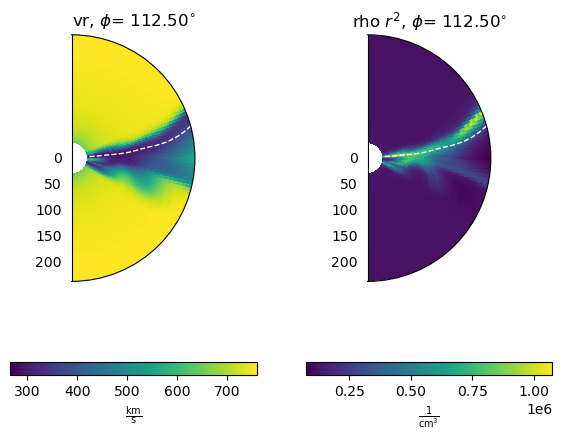

In [40]:
# Test ...
from psipy.data import sample_data

mas_path = sample_data.mas_sample_data()
model = MASOutput(mas_path)
print(mas_path) # sanity check
print(model.variables)

cbar_kwargs = {"orientation": "horizontal"}
phi_idx = 40

# Plotting equatorial slices
ax = plt.subplot(projection="polar")
model["vr"].plot_equatorial_cut(ax=ax, cbar_kwargs=cbar_kwargs)
plt.show()


# Plotting constant longitude slices
fig = plt.figure()
axs = [plt.subplot(1, 2, i + 1, projection="polar") for i in range(2)]

ax = axs[0]
model["vr"].plot_phi_cut(phi_idx, ax=ax, cbar_kwargs=cbar_kwargs)

ax = axs[1]
rho = model["rho"]
rho_r2 = rho.radial_normalized(2)
rho_r2.plot_phi_cut(phi_idx, ax=ax, cbar_kwargs=cbar_kwargs)

# Add a contour of br = 0 (the heliopsheric current sheet) to all the axes
for ax in axs:
    model["br"].contour_phi_cut(
        phi_idx, levels=[0], ax=ax, colors="white", linestyles="--", linewidths=1
    )
plt.show()

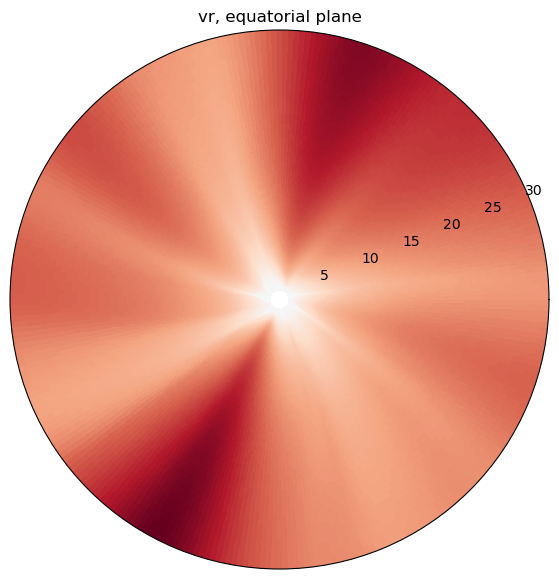

In [223]:
# Plotting equatorial slices
ax = plt.subplot(projection="polar")
im = model["vr"].plot_equatorial_cut(ax=ax)
im.colorbar.remove()
plt.show()

In [222]:
im.colorbar.remove()

In [220]:
[x for x in dir(im) if not x.startswith('_')]

['add_callback',
 'autoscale',
 'autoscale_None',
 'axes',
 'callbacks',
 'changed',
 'clipbox',
 'cmap',
 'colorbar',
 'colorbar_cid',
 'contains',
 'convert_xunits',
 'convert_yunits',
 'draw',
 'figure',
 'findobj',
 'format_cursor_data',
 'get_aa',
 'get_agg_filter',
 'get_alpha',
 'get_animated',
 'get_antialiased',
 'get_antialiaseds',
 'get_array',
 'get_capstyle',
 'get_children',
 'get_clim',
 'get_clip_box',
 'get_clip_on',
 'get_clip_path',
 'get_cmap',
 'get_coordinates',
 'get_cursor_data',
 'get_dashes',
 'get_datalim',
 'get_ec',
 'get_edgecolor',
 'get_edgecolors',
 'get_facecolor',
 'get_facecolors',
 'get_fc',
 'get_figure',
 'get_fill',
 'get_gid',
 'get_hatch',
 'get_in_layout',
 'get_joinstyle',
 'get_label',
 'get_linestyle',
 'get_linestyles',
 'get_linewidth',
 'get_linewidths',
 'get_ls',
 'get_lw',
 'get_mouseover',
 'get_offset_transform',
 'get_offsets',
 'get_path_effects',
 'get_paths',
 'get_picker',
 'get_pickradius',
 'get_rasterized',
 'get_sketch_para